## Import Modules

In [124]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [34]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [5]:
import os
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# Define or load your pre-trained model
# For example:
# from keras.applications import VGG16
# model = VGG16(...)

# Define BASE_DIR
BASE_DIR = r"C:\Users\admin\SEM_6\Sem6_projects\AOML"

features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    
    # Convert image pixels to numpy array
    image = img_to_array(image)
    
    # Reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # Preprocess image for the model
    image = preprocess_input(image)
    
    # Extract features
    feature = model.predict(image, verbose=0)
    
    # Get image ID
    image_id = img_name.split('.')[0]
    
    # Store feature
    features[image_id] = feature


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [58:02<00:00,  2.32it/s]


In [6]:
import os
import pickle

# Ensure WORKING_DIR exists
WORKING_DIR = "C:/Users/admin/SEM_6/Sem6_projects/AOML"  # Update with the correct path
if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

# Normalize path separators
pickle_file_path = os.path.join(WORKING_DIR, 'features.pkl')
pickle_file_path = os.path.normpath(pickle_file_path)

# Store features in pickle
with open(pickle_file_path, 'wb') as f:
    pickle.dump(features, f)


In [7]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [8]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 654880.45it/s]


In [10]:
len(mapping)

8091

## Preprocess Text Data

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8485

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key in data_keys:
            n += 1
            photo = features[key][0]
            for desc in mapping[key]:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Handle out-of-vocabulary words
                    if out_seq >= vocab_size:
                        # Skip this word or handle it as needed
                        continue
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n = 0


## Model Creation

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.utils import plot_model

# Assuming 'max_length' and 'vocab_size' are predefined
max_length = 100  # Example value, specify according to your dataset
vocab_size = 8485  # Example value, specify according to your dataset

# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model structure
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 100, 256)             2172160   ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['input_2[0][0]']             
                                                                                           

In [25]:
# train the model
epochs = 15
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


113/113 [==============================] - 2195s 19s/step - loss: 2.4854


In [27]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')


In [33]:
from keras.models import load_model

In [ ]:
model=load_model(WORKING_DIR+'/best_model.h5')

## Generate Captions for the Image

In [11]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [13]:
# generate caption for an image
def predict_caption(model='best_model.h5', image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

SyntaxError: non-default argument follows default argument (2604381326.py, line 2)

In [2]:
def predict_caption(image, tokenizer, max_length, model='best_model.h5'):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text


In [67]:
pip install nltk


     ---------------------------------------- 0.0/42.0 kB ? eta -:--:--
     ---------------------------------------- 42.0/42.0 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 32.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/269.5 kB ? eta -:--:--
   --------------------------------------- 269.5/269.5 kB 16.2 MB/s eta 0:00:00


In [31]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|████████████████████████████████████████████████████████████████████████████████| 810/810 [17:19<00:00,  1.28s/it]


BLEU-1: 0.539714
BLEU-2: 0.325695


## Visualize the Results

In [5]:
BASE_DIR = r"C:\Users\admin\SEM_6\Sem6_projects\AOML"

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with each other in the snow endseq


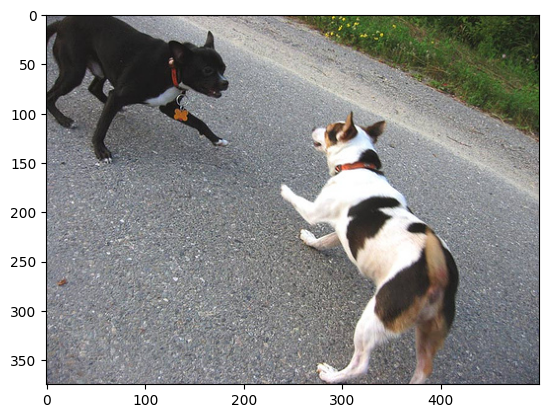

In [130]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq little girl is going down wooden stairs endseq


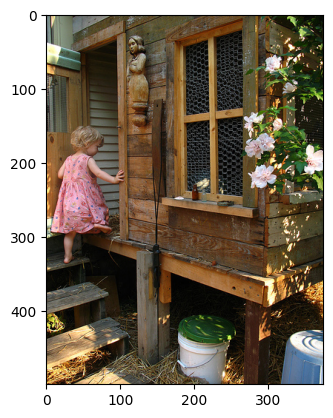

In [129]:
generate_caption("1000268201_693b08cb0e.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two skiers drapped skis drapped skis endseq


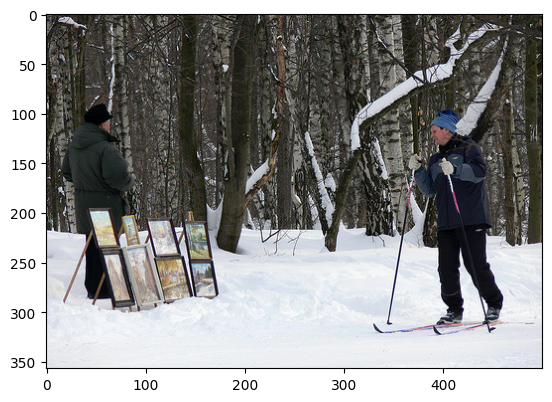

In [35]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq brown dog is sitting in some long grass endseq
startseq brown dog sits still on hillside endseq
startseq large tan dog sits on grassy hill endseq
startseq large yellow dog is sitting on hill endseq
startseq the dog is sitting on the side of the hill endseq
--------------------Predicted--------------------
startseq brown dog is jumping over the side of the grass endseq


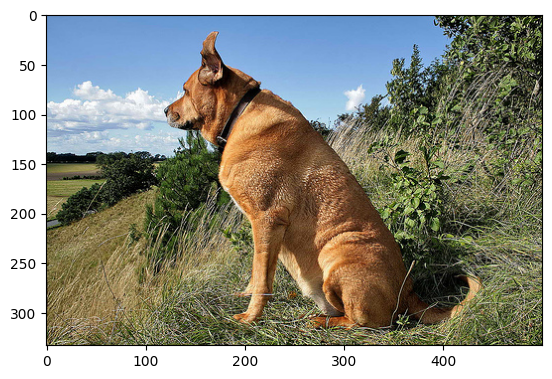

In [125]:
generate_caption("1319634306_816f21677f.jpg")

---------------------Actual---------------------
startseq baby swings in swing near wooden fence endseq
startseq baby wearing all white swinging on swing endseq
startseq little girl is swinging in baby swing on the playground endseq
startseq little girl rides in child 's swing endseq
startseq young baby girl wearing white outfit swinging in baby swing endseq
--------------------Predicted--------------------
startseq young boy is swinging on swing endseq


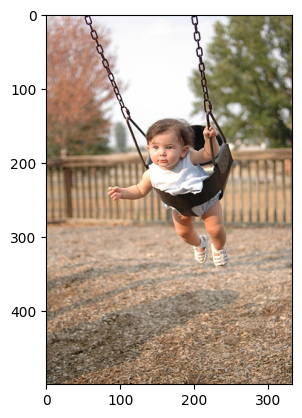

In [126]:
generate_caption("1332815795_8eea44375e.jpg")

---------------------Actual---------------------
startseq boy in an orange shirt grinds skateboard ramp endseq
startseq lone skateboarder wearing an orange shirt jumping on ramp endseq
startseq skateboarder uses ramp endseq
startseq "a young man in an orange shirt maneuvers skateboard at the top of ramp ." endseq
startseq skateboarder on ramp as seen through chain link fence endseq
--------------------Predicted--------------------
startseq skateboarder is flipping on ramp endseq


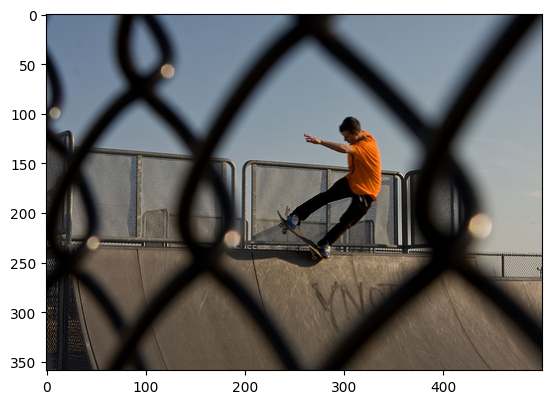

In [128]:
generate_caption("3366904106_e996320d20.jpg")

## Test with Real Image

In [131]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [145]:
image_path = 'test7.jpeg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(feature, tokenizer, max_length,model)

'startseq hiker is climbing cliff endseq'

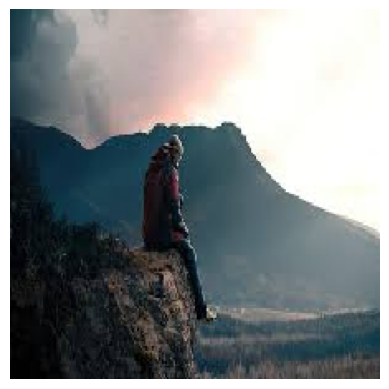

In [146]:
image = load_img(image_path, target_size=(224, 224))

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()